# Customer Lifetime Value

### The business world throws plenty of challenges to solve with the help of data everyday. Every business is built by its customers, so identifying and forecasting the potential of customers can help increase the revenue and growth of the business.

### Our aim here is to - 
1) Predict the number of visit of customer in next n days.

2) Predict the amount of transaction expected by a customer in those visits.

# Why choose BG-NBD model and not other usual regression models?

Lets take the example of image attached below. 

The X axis is the time period and Y axis is unique customers. 

As you can see the very first customer used to visit the store plenty of times in the beginning but now she has stopped visiting the store. In probabilistic modelling this is called as customer 'death'. So the probability of her visiting the store is very less. 

Where as the second customer hasn't been to store as many times as first customer but he has recently visited the store and also it is visible that he visits the store in quite some interval. So his probability to visit the store is more than first customer.

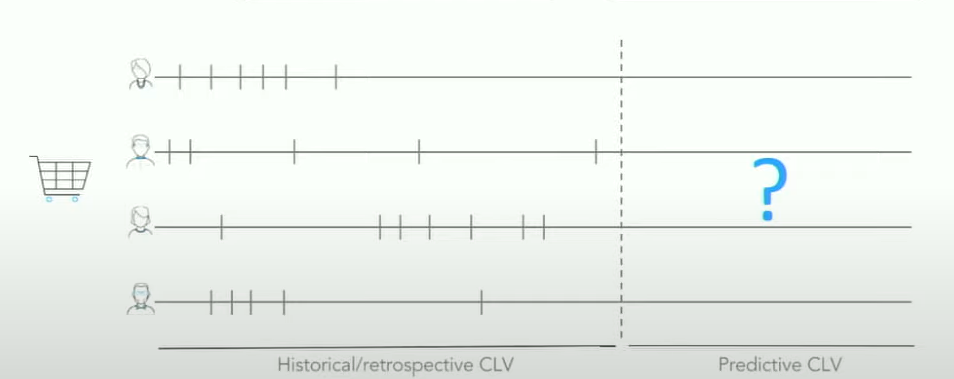

- The BG-NBD model calculates the probabily of the customer and classifies it as Alive or Dead. 

- If the customer is classified as 'Dead' then the number of visits in the next n days is 0 and the transaction amount is also 0. 

- If the customer is classified as 'Alive' then the number of visits is predicted and the number of visits predicted and monetary_value(average transaction amount in training data) is used to predict the future amount of transaction.

- In case of regression, the model averages past transaction values and inferes that the same number of purchase will be made in future, which fails the business logic as well as statistical modelling output.

In [ ]:
!pip install lifetimes

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import parser
from dateutil import relativedelta
from lifetimes import BetaGeoFitter
from lifetimes import ModifiedBetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data
from sklearn.metrics import mean_squared_error
from lifetimes.plotting import plot_frequency_recency_matrix 
from lifetimes import GammaGammaFitter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('../input/retailtransactiondata/Retail_Data_Transactions.csv', parse_dates=['trans_date'])
data.head()

In [ ]:
data.describe()

In [ ]:
data.quantile([0.1,0.2,0.25,0.4,0.5,0.6,0.75,0.8,0.9,0.95,0.97,1])

In [ ]:
sns.distplot(data.tran_amount)
plt.show()

The dataset here does not follow poisson distribution but we are taking this dataset for just demonstration purpose. We will get good results but not extremely accurate.

In [ ]:
df = data[['trans_date', 'tran_amount']]
df = df.groupby('trans_date').agg({'tran_amount':'sum'}).reset_index()

plt.figure(figsize=(30,5))
plt.plot(df.trans_date, df.tran_amount)
plt.show()

#### We can see there is no seasonality present in the data

In [ ]:
data['trans_date'] = pd.to_datetime(data['trans_date'], format="%Y-%m-%d").dt.date

In [ ]:
SPLIT_DATE = "2015-01-01" # Date to be used to end train date
PERIOD_LENGTH = 2.5 # Months
datex = parser.parse(SPLIT_DATE)
end_date = datex + relativedelta.relativedelta(months=3)
date2 = datex.date()
date3 = end_date.date()

train = data[data["trans_date"] < date2]
test = data[(data["trans_date"] >= date2) & (data["trans_date"] < date3)]

print("Start Train dataset date {}".format(train["trans_date"].min()))
print("End Train dataset date {}".format(train["trans_date"].max()))
print("---------------------------------------------")
print("Start Test dataset date {}".format(test["trans_date"].min()))
print("End Test dataset date {}".format(test["trans_date"].max()))

In [ ]:
train.head()

### We will use the typical RFM matrices in the model.
The calculation for all the facts are as follows -
- **Recency** = last purchase date - initial purchase date
- **Frequency**(Repeat) = Number of purchases except the first
- **T** = last date of training data set - first purchase date
- **Monetary_value** = Average transaction amount

The BG-NBD Model has a few assumptions which are -

1) Frequency follows a poisson distribution with rate (lambda).

2) Lifetime distribution follows an exponential distribution with slope (mu).

3) The latent paramenter lambda and mu are constrained by two prior gamma distributions.

In [ ]:
# Create Features (Frequency, Recency and T) for customers
features_train = summary_data_from_transaction_data(
    train,
    customer_id_col="customer_id",
    datetime_col="trans_date",
    monetary_value_col="tran_amount",
    freq="D",
)
features_train.reset_index(level=0, inplace=True)
features_train

In [ ]:
features_train.describe()

In [ ]:
bgf = ModifiedBetaGeoFitter(penalizer_coef=0.0000001)
bgf.fit(features_train['frequency'], features_train['recency'], features_train['T']) 
print(bgf)

In [ ]:
fig = plt.figure(figsize=(12,8)) 
plot_frequency_recency_matrix(bgf) 

In [ ]:
#Probability of customer still alive
from lifetimes.plotting import plot_probability_alive_matrix 
fig = plt.figure(figsize=(12,8)) 
plot_probability_alive_matrix(bgf) 

In [ ]:
from lifetimes.plotting import plot_period_transactions 
plot_period_transactions(bgf, max_frequency=45)

In [ ]:
customers = features_train[['customer_id']]

In [ ]:
# Predict future total amount spent for individual customers (next period)
t = PERIOD_LENGTH*30  # Days (1 Month aprox)
customers["pred_n_purchases"] = bgf.predict(
    t, features_train["frequency"], features_train["recency"], features_train["T"]
)

In [ ]:
y_predictions = customers[["customer_id", "pred_n_purchases"]]

test_n_purchases = (
    test["customer_id"]
    .value_counts()
    .rename_axis("customer_id")
    .to_frame("true_n_purchases")
)

dataset = pd.merge(y_predictions, test_n_purchases, on='customer_id', how='left')
dataset['true_n_purchases'].fillna(0, inplace= True) # No sales 
dataset['pred_n_purchases'].fillna(0, inplace= True) # No sales 

In [ ]:
y_true_n_purchases = dataset['true_n_purchases']
y_pred_n_purchases = dataset['pred_n_purchases']

In [ ]:
mean_squared_error(y_true_n_purchases, y_pred_n_purchases, squared=False)

In [ ]:
print('Number of purchases predicted:')
print(int(dataset['pred_n_purchases'].sum()))
print('--------------')
print('Number of purchases occured in actual:')
print(int(dataset['true_n_purchases'].sum()))

#### We can see that our model has performed extremely well in predicting the number of future visits by customers in next 2.5 months

This prediction is good in terms of overall visits. Since the data does not follow poisson distribution, therefore the model would not perform accurately at customer level.

In [ ]:
dataset['pred_n_purchases'] = round(dataset['pred_n_purchases'],0)
dataset.head(10)

In [ ]:
dataset.head(10)

In [ ]:
# Amount spent by customer current period
test_amount_spent = (
    test.groupby(["customer_id"])[["tran_amount"]]
    .agg("sum")
    .reset_index()
    .rename(columns={"tran_amount": "true_amount_spent_next_period"})
)

In [ ]:
features_train.describe()

In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0.1)
ggf.fit(features_train['frequency'],
        features_train['monetary_value'])
print(ggf)

In [ ]:
features_train["pred_amount_spent_next_period"] = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    features_train['frequency'],
    features_train['recency'],
    features_train['T'],
    features_train['monetary_value'],
    time=PERIOD_LENGTH, # months
    freq='D',
    discount_rate=0.01 # monthly discount rate
)
features_train.head()

In [ ]:
features_train.shape

In [ ]:
y_predictions = features_train[["customer_id", "pred_amount_spent_next_period"]]

In [ ]:
dataset = pd.merge(customers['customer_id'], y_predictions, on='customer_id', how='left')
dataset = pd.merge(dataset, test_amount_spent, on='customer_id', how='left')
dataset['pred_amount_spent_next_period'].fillna(0, inplace= True)
dataset['true_amount_spent_next_period'].fillna(0, inplace= True)

In [ ]:
dataset.describe()

In [ ]:
print('The sum of total Vol_PC predicted to be sold is:')
print(round(dataset['pred_amount_spent_next_period'].sum()),1)
print('------------')
print('The sum of total Vol_PC actually sold:')
print(dataset['true_amount_spent_next_period'].sum())

In [ ]:
y_true_amount_spent = dataset['true_amount_spent_next_period']
y_pred_amount_spent = dataset['pred_amount_spent_next_period']

In [ ]:
mean_squared_error(y_true_amount_spent, y_pred_amount_spent, squared=False)

Predicted and Actual Amount of transactions have a RMSE of 71.1 and this would be decreased if our prediction of number of visits is improved at customer level.

In [ ]:
dataset.describe()

In [ ]:
dataset['pred_amount_spent_next_period'] = round(dataset['pred_amount_spent_next_period'],1)

# We can export the variable 'dataset' in a csv to view the actual and predicted transaction at customer level

- Other probabilistic models used in non-contractual scenarios are:

  1) Parento/NBD Model
  
  2) BG/NBD Model
  
  3) BG/BB Model

https://www.linkedin.com/in/darshan-suri-7935b5104/